In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, label_binarize, OrdinalEncoder
#from category_encoders import CatBoostEncoder, MEstimateEncoder

from sklearn.ensemble import RandomForestClassifier, VotingClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.linear_model import RidgeClassifier, LogisticRegression, LinearRegression

from sklearn import set_config
import os

import optuna
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, mean_squared_error, precision_recall_curve, make_scorer, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, matthews_corrcoef
from scipy.stats import norm, skew

from colorama import Fore, Style, init
from copy import deepcopy
from sklearn.base import BaseEstimator, TransformerMixin
from pprint import pprint
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, StratifiedKFold, KFold, RepeatedKFold, cross_val_score, StratifiedGroupKFold
from xgboost import DMatrix, XGBClassifier, XGBRegressor
from lightgbm import log_evaluation, early_stopping, LGBMClassifier, LGBMRegressor, Dataset
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from tqdm.notebook import tqdm
from optuna.samplers import TPESampler, CmaEsSampler
from optuna.pruners import HyperbandPruner
from functools import partial
from IPython.display import display_html, clear_output
from sklearn.utils.class_weight import compute_class_weight
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings("ignore")

In [27]:
ITERATIONS = None
TASK_TYPE = "GPU"

In [28]:
from pathlib import Path
from datetime import datetime
import sys

# Define the base directory
base_dir = Path.cwd().resolve().parents[1]

# Define subdirectories
data_dir = base_dir / "data"
model_dir = base_dir / "models"
notebooks_dir = base_dir / "notebooks"

# Create a timestamped directory for AutoGluon
# autogluon_folder = base_dir / "AutogluonModels" / f"ag-{datetime.now():%Y%m%d_%H%M%S}"

# Append base_dir to sys.path
sys.path.append(str(base_dir))

# <span style="border-radius: 30px; color: white; background-color:#3cb371; padding: 5px 20px 5px 20px">Config</span>

In [29]:
import joblib
class Config:
    
    state = 42
    n_splits = 10
    early_stop = 200
        
    target = 'Premium Amount'
    
    train = pd.read_csv(data_dir/'train.csv', index_col='id')
    test = pd.read_csv(data_dir/'test.csv', index_col='id')
    nonlog_train , nonlog_test = joblib.load("nonlog_feature/cat_non_loged.pkl")
    
    train['nonlog'] = nonlog_train
    test['nonlog'] = nonlog_test
    
    submission = pd.read_csv(data_dir/'sample_submission.csv')

    original_data = 'N'
    outliers = 'N'
    log_trf = 'Y'
    scaler_trf = 'N'
    feature_eng = 'Y'
    missing = 'Y'

# <span style="border-radius: 30px; color: white; background-color:#3cb371; padding: 5px 20px 5px 20px">Data Transformation</span>

In [30]:
Config.test

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,nonlog
id,,,,,,,,,,,,,,,,,,,,
1200000,28.0,Female,2310.0,NaN,4.0,Bachelor's,Self-Employed,7.657981,Rural,Basic,NaN,19.0,NaN,1.0,2023-06-04 15:21:39.245086,Poor,Yes,Weekly,House,1280.226711
1200001,31.0,Female,126031.0,Married,2.0,Master's,Self-Employed,13.381379,Suburban,Premium,NaN,14.0,372.0,8.0,2024-04-22 15:21:39.224915,Good,Yes,Rarely,Apartment,1280.627536
1200002,47.0,Female,17092.0,Divorced,0.0,PhD,Unemployed,24.354527,Urban,Comprehensive,NaN,16.0,819.0,9.0,2023-04-05 15:21:39.134960,Average,Yes,Monthly,Condo,1098.265526
1200003,28.0,Female,30424.0,Divorced,3.0,PhD,Self-Employed,5.136225,Suburban,Comprehensive,1.0,3.0,770.0,5.0,2023-10-25 15:21:39.134960,Poor,Yes,Daily,House,1080.835132
1200004,24.0,Male,10863.0,Divorced,2.0,High School,Unemployed,11.844155,Suburban,Premium,NaN,14.0,755.0,7.0,2021-11-26 15:21:39.259788,Average,No,Weekly,House,1099.509965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,50.0,Female,38782.0,Married,1.0,Bachelor's,NaN,14.498639,Rural,Premium,NaN,8.0,309.0,2.0,2021-07-09 15:21:39.184157,Average,Yes,Daily,Condo,1176.696581
1999996,NaN,Female,73462.0,Single,0.0,Master's,NaN,8.145748,Rural,Basic,2.0,0.0,NaN,2.0,2023-03-28 15:21:39.250151,Good,No,Daily,Apartment,1494.775916
1999997,26.0,Female,35178.0,Single,0.0,Master's,Employed,6.636583,Urban,Comprehensive,NaN,10.0,NaN,6.0,2019-09-30 15:21:39.132191,Poor,No,Monthly,Apartment,1157.719971


In [31]:
class Transform(Config):
    
    def __init__(self):
        super().__init__()
        if Config.original_data == 'Y':
            self.train = pd.concat([self.train, self.train_org], ignore_index=True).drop_duplicates()
            self.train.reset_index(drop=True, inplace=True)

        self.num_features = self.train.drop(self.target, axis=1).select_dtypes(exclude=['object', 'bool']).columns.tolist()
        self.cat_features = self.train.drop(self.target, axis=1).select_dtypes(include=['object', 'bool']).columns.tolist()
        
        if self.missing == 'Y':
            self.missing_values()
            
        self.train_raw = self.train.copy()
        
        if self.feature_eng == 'Y':
            self.train = self.new_features(self.train)
            self.test = self.new_features(self.test)
            self.train_raw = self.new_features(self.train_raw)
            
        self.num_features = self.train.drop(self.target, axis=1).select_dtypes(exclude=['object', 'bool']).columns.tolist()
        self.cat_features = self.train.drop(self.target, axis=1).select_dtypes(include=['object', 'bool']).columns.tolist()
            
        if self.outliers == 'Y':    
            self.remove_outliers()
            
        if self.log_trf == 'Y':
            self.log_transformation()
            
        if self.scaler_trf == 'Y':
            self.scaler()
            
        self.train_enc = self.train.copy()
        self.test_enc = self.test.copy()
        self.encode()
        
        if self.outliers == 'Y' or self.log_trf == 'Y' or self.scaler_trf =='Y':
            self.distribution()
        
    def __call__(self):

        self.train[self.cat_features] = self.train[self.cat_features].astype('category')
        self.test[self.cat_features] = self.test[self.cat_features].astype('category')

        self.cat_features_card = []
        for f in self.cat_features:
            self.cat_features_card.append(self.train[f].nunique())

        self.train = self.reduce_mem(self.train)
        self.test = self.reduce_mem(self.test)
        
        self.y = self.train[self.target]
        self.train = self.train.drop(self.target, axis=1)
        self.train_enc = self.train_enc.drop(self.target, axis=1)
        
        return self.train, self.train_enc, self.y, self.test, self.test_enc, self.cat_features
    
    def encode(self):
        data = pd.concat([self.test, self.train])
        oe = OrdinalEncoder()
        data[self.cat_features] = oe.fit_transform(data[self.cat_features]).astype('int')
        
        scaler = StandardScaler()
        data[self.num_features + [self.target]] = scaler.fit_transform(data[self.num_features + [self.target]])
        
        self.train_enc = data[~data[self.target].isna()]
        self.test_enc = data[data[self.target].isna()].drop(self.target, axis=1)
            
    def new_features(self, data): 
        data['Policy Start Date'] = pd.to_datetime(data['Policy Start Date'])
        data['Year'] = data['Policy Start Date'].dt.year
        data['Day'] = data['Policy Start Date'].dt.day
        data['Month'] = data['Policy Start Date'].dt.month
        data["Weekday"] = data["Policy Start Date"].dt.weekday
        data.drop('Policy Start Date', axis=1, inplace=True)
        return data

    def log_transformation(self):
        self.train[self.target] = np.log1p(self.train[self.target]) 
        
        return self
    
    def distribution(self):
        num_features = self.num_features + [self.target]
        print(Style.BRIGHT+Fore.GREEN+f'\nHistograms of distribution\n')
        fig, axes = plt.subplots(nrows=len(num_features), ncols=2, figsize=(15, len(num_features)*5))

        for (ax_r, ax_n), col in zip(axes, num_features):

            ax_r.set_title(f'{col} ($\mu=$ {self.train_raw[col].mean():.2f} and $\sigma=$ {self.train_raw[col].std():.2f} )')
            ax_r.hist(self.train_raw[col], bins=30, color='#3cb371')
            ax_r.axvline(self.train_raw[col].mean(), color='r', label='Mean')
            ax_r.axvline(self.train_raw[col].median(), color='y', linestyle='--', label='Median')
            ax_r.legend()

            ax_n.set_title(f'{col} Normalized ($\mu=$ {self.train_enc[col].mean():.2f} and $\sigma=$ {self.train_enc[col].std():.2f} )')
            ax_n.hist(self.train_enc[col], bins=30, color='#3cb371')
            ax_n.axvline(self.train_enc[col].mean(), color='r', label='Mean')
            ax_n.axvline(self.train_enc[col].median(), color='y', linestyle='--', label='Median')
            ax_n.legend()
        
    def remove_outliers(self):
        Q1 = self.train[self.targets].quantile(0.25)
        Q3 = self.train[self.targets].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5*IQR
        upper_limit = Q3 + 1.5*IQR
        self.train = self.train[(self.train[self.targets] >= lower_limit) & (self.train[self.targets] <= upper_limit)]
        self.train.reset_index(drop=True, inplace=True) 
        
    def scaler(self):
        scaler = StandardScaler()
        self.train[self.num_features] = scaler.fit_transform(self.train[self.num_features])
        self.test[self.num_features] = scaler.transform(self.test[self.num_features])
        return self
    
    def missing_values(self):

        self.train[self.cat_features] = self.train[self.cat_features].fillna('None')
        self.test[self.cat_features] = self.test[self.cat_features].fillna('None')
        return self

    def reduce_mem(self, df):

        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', "uint16", "uint32", "uint64"]
        
        for col in df.columns:
            col_type = df[col].dtypes
            
            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()

                if "int" in str(col_type):
                    if c_min >= np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min >= np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min >= np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min >= np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min >= np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    if c_min >= np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)  

        return df


Histograms of distribution



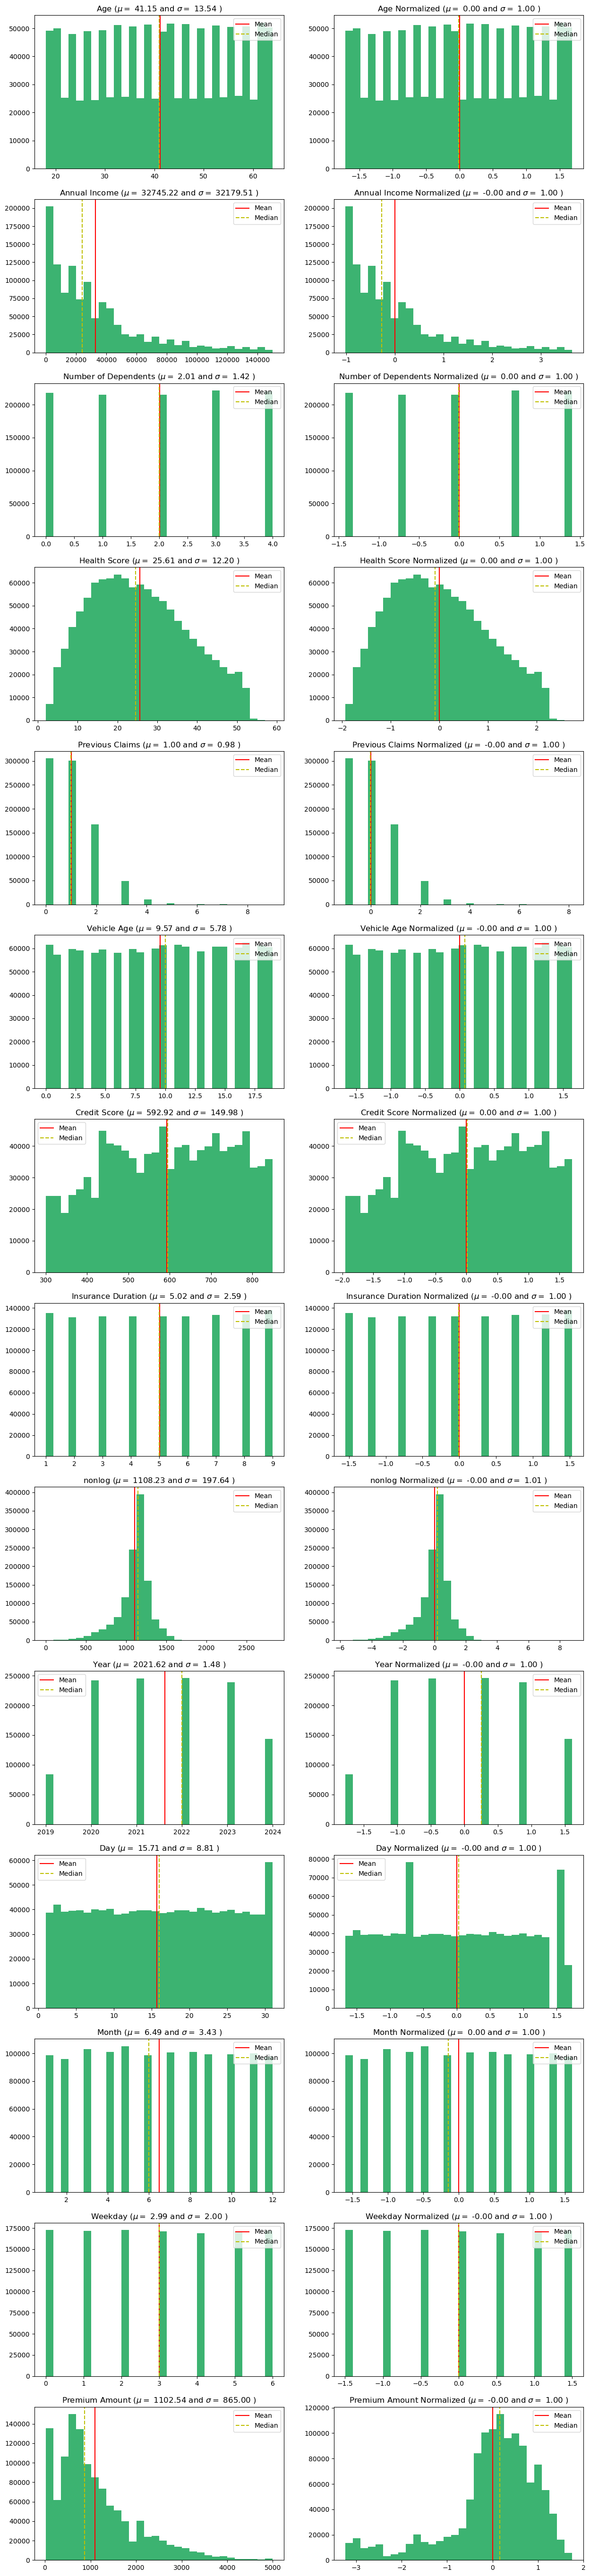

In [32]:
t = Transform()
X, X_enc, y, test, test_enc, cat_features = t()

In [33]:
test_enc

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,...,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,nonlog,Year,Day,Month,Weekday
id,,,,,,,,,,,,,,,,,,,,,
1200000,-0.970664,0,-0.946271,2,1.405088,0,2,-1.471187,0,0,...,-1.549096,3,1,3,2,0.880020,0.934139,-1.329422,-0.143323,1.501091
1200001,-0.749084,0,2.897414,1,-0.006844,2,2,-1.002241,1,2,...,1.149334,1,1,2,0,0.882071,1.611532,0.714009,-0.726039,-1.495843
1200002,0.432679,0,-0.487033,0,-1.418776,3,3,-0.103159,2,1,...,1.534824,0,1,1,1,-0.051205,0.934139,-1.215898,-0.726039,-0.496865
1200003,-0.970664,0,-0.072843,0,0.699122,3,2,-1.677807,1,1,...,-0.007136,3,1,0,2,-0.140409,0.934139,1.054581,1.022108,-0.496865
1200004,-1.266105,1,-0.680552,0,-0.006844,1,3,-1.128194,1,2,...,0.763844,0,0,3,2,-0.044836,-0.420646,1.168105,1.313466,0.502113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,0.654260,0,0.186818,1,-0.712810,0,1,-0.910699,0,2,...,-1.163606,0,1,0,1,0.350183,-0.420646,-0.761803,0.148034,0.502113
1999996,NaN,0,1.264234,3,-1.418776,2,1,-1.431222,0,0,...,-1.163606,1,0,0,0,1.978020,0.934139,1.395153,-1.017397,-0.996354
1999997,-1.118384,0,0.074851,3,-1.418776,2,0,-1.554875,2,1,...,0.378354,3,0,1,0,0.253066,-1.775431,1.622201,0.730750,-1.495843


# <span style="border-radius: 30px; color: white; background-color:#3cb371; padding: 5px 20px 5px 20px">Model Training</span>

In [37]:
from axyom_utilities.wrappers import HGBMRegressorWrapper, YggdrasilRegressorWrapper
import ydf

models = {
    # 'NN': [_,
    #        True],
    'CAT': [CatBoostRegressor(**{'verbose': 0,
                                  'random_state': Config.state,
                                  'cat_features': cat_features,
                                  'early_stopping_rounds': Config.early_stop,
                                  'eval_metric': "RMSE",
                                  'task_type':TASK_TYPE,  # Enable GPU
                                  'n_estimators' : 2000 if ITERATIONS is None else ITERATIONS
                              }),
            False],
    'CAT2': [CatBoostRegressor(**{'verbose': 0,
                                  'random_state': Config.state,
                                  'cat_features': cat_features,
                                  'early_stopping_rounds': Config.early_stop,
                                  'eval_metric': "RMSE",
                                  'n_estimators' : 3000 if ITERATIONS is None else ITERATIONS,
                                 'objective': 'RMSE', 
                                 'depth': 11,
                                 'min_data_in_leaf': 78,
                                 'l2_leaf_reg': 6.628202811121375,
                                 'max_bin': 8000,
                                 'learning_rate': 0.01,
                                  'task_type':TASK_TYPE,  # Enable GPU
                              }),
            False],
    'CAT3': [CatBoostRegressor(**{'verbose': 0,
                                  'random_state': Config.state,
                                  'cat_features': cat_features,
                                  'early_stopping_rounds': 200,
                                  'eval_metric': "RMSE",
                                  'objective': 'RMSE', 
                                  'depth': 11,
                                  'min_data_in_leaf': 72, 
                                  'l2_leaf_reg': 2.005119577280367,
                                  "iterations" : 3000 if ITERATIONS is None else ITERATIONS,
                                  'learning_rate': 0.01,
                                  'max_bin': 8000,
                                  'task_type':TASK_TYPE,  # Enable GPU
                             }),
        False],
    'CAT4': [CatBoostRegressor(**{'verbose': 0,
                                  'random_state': Config.state,
                                  'cat_features': cat_features,
                                  'early_stopping_rounds': 200,
                                  'eval_metric': "RMSE",
                                  'objective': 'RMSE', 
                                  'depth': 13, 
                                  'subsample': 0.9998449533801151,
                                  'min_data_in_leaf': 63,
                                  'l2_leaf_reg': 0.3242106539167982,
                                  "iterations" : 3000 if ITERATIONS is None else ITERATIONS,
                                  'learning_rate': 0.01,
                                  'max_bin': 8000,
                                  'bootstrap_type': 'Poisson',
                                  'task_type':TASK_TYPE,  # Enable GPU
                         }),
            False],
    
    'CAT5': [CatBoostRegressor(**{'objective': 'RMSE',
                                   'depth': 11,
                                   'subsample': 0.9581878706329088,
                                   'min_data_in_leaf': 43,
                                   'l2_leaf_reg': 0.08249502036269224,
                                   'verbose': 0,
                                   'random_state': Config.state,
                                   'cat_features': cat_features,
                                   'early_stopping_rounds': 200,
                                   'eval_metric': "RMSE",
                                   'task_type': "GPU",
                                    "iterations" : 5000,
                                   'learning_rate': 0.005,
                                   'max_bin': 8000,
                                   'bootstrap_type': 'Bernoulli'
                                  }),
              False],
    
     'CAT6': [CatBoostRegressor(**{'objective': 'RMSE',
                                   'logging_level': 'Silent',
                                   'depth': 11,
                                   'min_data_in_leaf': 62,
                                   'l2_leaf_reg': 7.887761285633826,
                                   'random_state': Config.state,
                                   'cat_features': cat_features,
                                   'early_stopping_rounds': 300,
                                   'eval_metric': "RMSE",
                                   'task_type': "GPU",
                                    "iterations" : 5000,
                                   'learning_rate': 0.01,
                                   'max_bin': 8000,
                                   'bootstrap_type': 'Poisson'
                                  }),
              False],
     
     'CAT8': [CatBoostRegressor(**{'objective': 'RMSE',
                                   'depth': 11, 
                                   'min_data_in_leaf': 51, 
                                   'l2_leaf_reg': 7.51216069323258,
                                   'random_state': Config.state,
                                   'cat_features': cat_features,
                                   'early_stopping_rounds': 200,
                                   'eval_metric': "RMSE",
                                   'task_type': "GPU",
                                    "iterations" : 5000,
                                   'learning_rate': 0.01,
                                   'max_bin': 8000,
                                   'bootstrap_type': 'Bernoulli'
                                  }),
              False],
     'CAT9': [CatBoostRegressor(**{'objective': 'RMSE',
                                   'depth': 10, 
                                   'min_data_in_leaf': 18,
                                   'l2_leaf_reg': 9.044302614615026,
                                   'random_state': Config.state,
                                   'cat_features': cat_features,
                                   'early_stopping_rounds': 200,
                                   'eval_metric': "RMSE",
                                   'task_type': "GPU",
                                    "iterations" : 5000,
                                   'learning_rate': 0.01,
                                   'max_bin': 8000,
                                   'bootstrap_type': 'Bernoulli'
                                  }),
          False],
    'XGB': [XGBRegressor(**{'tree_method': 'hist',
                             'n_estimators': 2000 if ITERATIONS is None else ITERATIONS,
                             'objective': 'reg:squarederror',
                             'random_state': Config.state,
                             'enable_categorical': True,
                             'verbosity': 0,
                             'early_stopping_rounds': Config.early_stop,
                             'eval_metric': 'rmse',
                           }),
            False],
    'XGB2': [XGBRegressor(**{'tree_method': 'hist',
                             'n_estimators': 2000 if ITERATIONS is None else ITERATIONS,
                             'objective': 'reg:squarederror',
                             'random_state': Config.state,
                             'enable_categorical': True,
                             'verbosity': 0,
                             'early_stopping_rounds': Config.early_stop,
                             'eval_metric': 'rmse',
                            'booster': 'gbtree',
                            'max_depth': 9,
                            'learning_rate': 0.0031740845858378402, 
                            'min_child_weight': 16,
                            'subsample': 0.8666770334099294,
                            'reg_alpha': 0.191908421033219,
                            'reg_lambda': 0.7995814007464592,
                            'colsample_bytree': 0.9669446980405391,
                            'random_state': 42,
                            'objective': 'reg:squarederror',
                            'n_jobs': -1,
                           }),
            False],
    'XGB3': [XGBRegressor(**{'booster': 'gbtree', 
                             'max_depth': 9,
                             'min_child_weight': 13,
                             'subsample': 0.8626964099130539,
                             'reg_alpha': 0.058057084885141746,
                             'reg_lambda': 0.6326297976784753,
                             'colsample_bytree': 0.8940282896063437,
                             'n_jobs': -1,
                             'learning_rate': 0.01,
                             'max_bin': 8000,
                             'tree_method': 'hist',
                             'n_estimators': 2000 if ITERATIONS is None else ITERATIONS,
                             'objective': 'reg:squarederror',
                             'random_state': Config.state,
                             'enable_categorical': True,
                             'verbosity': 0,
                             'early_stopping_rounds': Config.early_stop,
                             'eval_metric': 'rmse',
                            }),
             False],
    'XGB4': [XGBRegressor(**{'booster': 'gbtree',
                             'max_depth': 8,
                             'min_child_weight': 17,
                             'subsample': 0.8926967587245219,
                             'reg_alpha': 0.2968941900087133,
                             'reg_lambda': 0.8270727714379025,
                             'colsample_bytree': 0.9318890724874014,
                             'n_jobs': -1,
                             'learning_rate': 0.01,
                             'max_bin': 8000,
                             'tree_method': 'hist',
                             'n_estimators': 3000 if ITERATIONS is None else ITERATIONS,
                             'objective': 'reg:squarederror',
                             'random_state': Config.state,
                             'enable_categorical': True,
                             'verbosity': 0,
                             'early_stopping_rounds': Config.early_stop,
                             'eval_metric': 'rmse',
                            }),
             False],
    'XGB5': [XGBRegressor(**{'booster': 'gbtree', 
                             'max_depth': 9,
                             'min_child_weight': 13,
                             'subsample': 0.8950190330733485, 
                             'reg_alpha': 0.3530275785494063,
                             'reg_lambda': 0.9564526039891854, 
                             'colsample_bytree': 0.8488129245455193,
                             'random_state': 42,
                             'objective': 'reg:squarederror',
                             'n_jobs': -1,
                             'learning_rate': 0.01,
                             'max_bin': 8000,
                             'tree_method': 'hist',
                             'n_estimators': 3000 if ITERATIONS is None else ITERATIONS,
                             'objective': 'reg:squarederror',
                             'random_state': Config.state,
                             'enable_categorical': True,
                             'verbosity': 0,
                             'early_stopping_rounds': Config.early_stop,
                             'eval_metric': 'rmse',
                            }),
             False],
    
    'XGB6': [XGBRegressor(**{'booster': 'gbtree',
                              'max_depth': 10, 
                              'min_child_weight': 19,
                              'subsample': 0.8882395046974123,
                              'reg_alpha': 0.12361226000167053,
                              'reg_lambda': 0.7568174249367466,
                              'colsample_bytree': 0.83845902004046,
                              'objective': 'reg:squarederror',
                              'n_jobs': -1,
                              'learning_rate': 0.01,
                              'max_bin': 8000,
                              'tree_method': 'hist',
                              'n_estimators': 5000,
                              'random_state': Config.state,
                              'enable_categorical': True,
                              'verbosity': 0,
                              'early_stopping_rounds': Config.early_stop,
                              'eval_metric': 'rmse',
                             'device': "cuda",
                             }),
              False],
    'XGB8': [XGBRegressor(**{'booster': 'gbtree',
                             'max_depth': 10,
                             'min_child_weight': 11,
                             'subsample': 0.8709310286076404, 
                             'reg_alpha': 0.2429313136646974,
                             'reg_lambda': 0.9443233420006127,
                             'colsample_bytree': 0.8004450303825076,
                             'random_state': 42, 
                             'objective': 'reg:squarederror', 
                             'n_jobs': -1,
                             'learning_rate': 0.01,
                              'max_bin': 8000,
                              'tree_method': 'hist',
                              'n_estimators': 5000,
                              'random_state': Config.state,
                              'enable_categorical': True,
                              'verbosity': 0,
                              'early_stopping_rounds': Config.early_stop,
                              'eval_metric': 'rmse',
                             'device': "cuda",
                            }),
             False],
    'LGBM': [LGBMRegressor(**{'random_state': Config.state,
                               'early_stopping_round': Config.early_stop,
                               'categorical_feature': cat_features,
                               'verbose': -1,
                               'boosting_type': 'gbdt',
                               'n_estimators': 3000 if ITERATIONS is None else ITERATIONS,
                               'eval_metric': 'rmse',
                              'objective': 'regression_l2',
                              }),
             False],
    'LGBM2': [LGBMRegressor(**{'random_state': Config.state,
                               'early_stopping_round': Config.early_stop,
                               'categorical_feature': cat_features,
                               'verbose': -1,
                               'boosting_type': 'gbdt',
                               'n_estimators': 3000 if ITERATIONS is None else ITERATIONS,
                               'eval_metric': 'rmse',
                              'objective': 'regression_l2',
                              'max_depth': 9,
                              'num_leaves': 722,
                              'min_child_samples': 27,
                              'min_child_weight': 14,
                              'colsample_bytree': 0.49498912736255835,
                              'reg_alpha': 0.3428923649002299, 
                              'reg_lambda': 0.6429288241470125,
                               'learning_rate': 0.01,
                              }),
             False],
    'LGBM3': [LGBMRegressor(**{'random_state': Config.state,
                               'early_stopping_round': Config.early_stop,
                               'categorical_feature': cat_features,
                               'verbose': -1,
                               'boosting_type': 'gbdt',
                               'n_estimators': 3000 if ITERATIONS is None else ITERATIONS,
                               'eval_metric': 'rmse',
                              'objective': 'regression_l2',
                              'learning_rate': 0.01,
                               'max_bin': 8000,
                               'max_depth': 8, 
                               'num_leaves': 796,
                               'min_child_samples': 21,
                               'min_child_weight': 11,
                               'colsample_bytree': 0.48551477424501904, 
                               'reg_alpha': 0.44307695050069845, 
                               'reg_lambda': 0.9310703189038081, 
                              }),
             False],
    'LGBM4': [LGBMRegressor(**{'objective': 'regression_l2',
                               'metric': 'rmse',
                               'max_depth': 10, 
                               'num_leaves': 133,
                               'min_child_samples': 18, 
                               'min_child_weight': 14, 
                               'colsample_bytree': 0.4997666632394159, 
                               'reg_alpha': 0.2813104886322961, 
                               'reg_lambda': 0.8049716583639613,
                               'random_state': Config.state,
                               'early_stopping_round': Config.early_stop,
                               'categorical_feature': cat_features,
                               'verbose': -1,
                               'boosting_type': 'goss',
                               'n_estimators': 3000 if ITERATIONS is None else ITERATIONS,
                              'learning_rate': 0.01,
                              }),
              False],
    'LGBM5': [LGBMRegressor(**{'objective': 'regression_l2',
                                'metric': 'rmse',
                                'max_depth': 12, 
                                'num_leaves': 675, 
                                'min_child_samples': 10,
                                'min_child_weight': 19,
                                'colsample_bytree': 0.49534353968335604,
                                'reg_alpha': 0.3747939308000606,
                                'reg_lambda': 0.5472625114112711, 
                                'random_state': Config.state,
                               'early_stopping_round': Config.early_stop,
                                'categorical_feature': cat_features,
                                'verbose': -1,
                                'n_estimators': 5000,
                               'learning_rate': 0.01,
                                'max_bin': 8000,
                             }),
              False],
     'LGBM6': [LGBMRegressor(**{'objective': 'regression_l2',
                                'metric': 'rmse',
                                'max_depth': 12,
                                'num_leaves': 246,
                                'min_child_samples': 10,
                                'min_child_weight': 24,
                                'colsample_bytree': 0.49704729723832064,
                                'reg_alpha': 0.2791624804454722,
                                'reg_lambda': 0.7306747260034717,
                                'random_state': Config.state,
                                'early_stopping_round': Config.early_stop,
                                'categorical_feature': cat_features,
                                'verbose': -1,
                                'n_estimators': 5000,
                               'learning_rate': 0.01,
                                'max_bin': 8000
                              }),
               False],
    'LGBM8': [LGBMRegressor(**{'objective': 'regression_l2',
                               'metric': 'rmse', 
                               'max_depth': 7,
                               'num_leaves': 108,
                               'min_child_samples': 13,
                               'min_child_weight': 22,
                               'colsample_bytree': 0.4781013294503911,
                               'reg_alpha': 0.35450860719581045, 
                               'reg_lambda': 0.6395930802901353, 
                               'random_state': Config.state,
                               'early_stopping_round': Config.early_stop,
                               'categorical_feature': cat_features,
                               'verbose': -1,
                               'boosting_type': 'goss',
                               'n_estimators': 5000,
                               'learning_rate': 0.01,
                               'max_bin': 8000,
                              }),
              False],
    'LGBM9': [LGBMRegressor(**{'objective': 'regression_l2',
                                'metric': 'rmse',
                                'max_depth': 11,
                                'num_leaves': 169, 
                                'min_child_samples': 27,
                                'min_child_weight': 13,
                                'colsample_bytree': 0.4844468439076937,
                                'reg_alpha': 0.08086875774692211, 
                                'reg_lambda': 0.9676995833820066,
                                'random_state': Config.state,
                               'early_stopping_round': Config.early_stop,
                               'categorical_feature': cat_features,
                               'verbose': -1,
                               'n_estimators': 5000,
                               'learning_rate': 0.01,
                               'max_bin': 8000,
                           }),
               False],
    'HGB': [HGBMRegressorWrapper(**{'max_depth': 13,
                                             'learning_rate': 0.08814188960134894,
                                             'loss': 'squared_error',
                                             'l2_regularization': 1.518602886724097,
                                             'min_samples_leaf': 37,
                                             'max_leaf_nodes': 40,
                                             'max_iter': 3000 if ITERATIONS is None else ITERATIONS,
                                             'random_state': 42,
                                             'early_stopping': "auto"
                                            }),
            False],
    'HGB2': [HGBMRegressorWrapper(**{'max_depth': 13,
                                              'learning_rate': 0.026862116662879427,
                                              'loss': 'squared_error', 
                                              'l2_regularization': 0.040027066827640706,
                                              'min_samples_leaf': 33,
                                              'max_leaf_nodes': 39,
                                             'max_iter': 3000 if ITERATIONS is None else ITERATIONS,
                                             'random_state': Config.state,
                                             'early_stopping': "auto"
                                            }),
            False],
    'HGB3': [HGBMRegressorWrapper(**{'max_depth': 14,
                                              'learning_rate': 0.012284533985518386,
                                              'loss': 'squared_error',
                                              'l2_regularization': 4.037780478249763,
                                              'min_samples_leaf': 40,
                                              'max_leaf_nodes': 40,
                                              'max_iter': 5000,
                                              'random_state': Config.state,
                                              #'early_stopping': Config.early_stop
                                             }),
             False],
     'HGB4': [HGBMRegressorWrapper(**{'max_depth': 12,
                                               'loss': 'squared_error',
                                               'l2_regularization': 5.24776999351151e-09,
                                               'min_samples_leaf': 26,
                                               'max_leaf_nodes': 39,
                                               'learning_rate': 0.005,
                                               'max_iter': 5000,
                                               'random_state': Config.state,
                                               #'early_stopping': Config.early_stop
                                              }),
              False],
    'YDF': [YggdrasilRegressorWrapper(**{'num_trees': 1000,
                                        'max_depth': 13,
                                        'task':ydf.Task.REGRESSION
                                        }),
            True],
}

In [38]:
class Model(Config):
    
    def __init__(self, X, X_enc, y, test, test_enc, models):
        self.y = y
        self.models = models
        self.scores = pd.DataFrame(columns=['Score'])
        self.OOF_preds = pd.DataFrame()
        self.TEST_preds = pd.DataFrame()
    def train(self):
        
        folds = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.state)
 
        for model_name, [model, training] in tqdm(self.models.items()):
            
            if training:
                print('='*20)
                print(model_name)
                if any(model in model_name for model in ['LGBM', 'CAT', 'XGB']):
                    self.X = X
                    self.test = test
 
                else:
                    self.X = X_enc
                    self.test = test_enc
                    
                if 'NN' in model_name:
                    pass
                        
                else:
                    for n_fold, (train_id, valid_id) in enumerate(folds.split(self.X, self.y)):
                        X_train, y_train = self.X.iloc[train_id], self.y.iloc[train_id]
                        X_val, y_val = self.X.iloc[valid_id], self.y.iloc[valid_id]

                        oof_preds = pd.DataFrame(columns=[model_name], index=X_val.index)
                        test_preds = pd.DataFrame(columns=[model_name], index=test.index)
                        print(f'Fold {n_fold+1}')

                        if "XGB" in model_name:
                            model.fit(X_train, y_train, 
                                      eval_set = [(X_val, y_val)], 
                                      verbose = False
                                     )

                        elif "CAT" in model_name:
                            model.fit(X_train, y_train, 
                                      eval_set = [(X_val, y_val)],
                                      verbose=False
                                      ) 

                        elif "LGBM" in model_name:
                             model.fit(X_train, y_train, 
                                       eval_set = [(X_val, y_val)], 
                                       callbacks = [log_evaluation(0),
                                                    early_stopping(self.early_stop, verbose = False)
                                                   ])  

                        else:
                            model.fit(
                                X_train,
                                y_train,
                                eval_set=(X_val, y_val),  # Provide validation set explicitly
                                early_stopping_rounds=self.early_stop,        # Enable early stopping
                                verbose=0                   # Suppress training output for clarity
                            )

                        y_pred_val = model.predict(X_val)
                        test_pred = model.predict(self.test)
                       
                        score = mean_squared_error(y_val, y_pred_val, squared=False)
                        print(score)
                        self.scores.loc[f'{model_name}', f'Fold {n_fold+1}'] = score

                        oof_preds[model_name] = y_pred_val
                        test_preds[model_name] = test_pred
                        self.OOF_preds = pd.concat([self.OOF_preds, oof_preds], axis = 0, ignore_index = False)
                        self.TEST_preds = pd.concat([self.TEST_preds, test_preds], axis = 0, ignore_index = False)

                self.OOF_preds = self.OOF_preds.groupby(level=0).mean()
                self.TEST_preds = self.TEST_preds.groupby(level=0).mean()

                self.OOF_preds[f'{model_name}'].to_csv(f'{model_name}_oof.csv', index=False)
                self.TEST_preds[f'{model_name}'].to_csv(f'{model_name}_test.csv', index=False)
            
            else:
                self.OOF_preds[f'{model_name}'] = pd.read_csv(f'{model_name}_oof.csv')
                self.TEST_preds[f'{model_name}'] = pd.read_csv(f'{model_name}_test.csv')
                
                for n_fold, (train_id, valid_id) in enumerate(folds.split(self.OOF_preds[f'{model_name}'], self.y)):
                    y_pred_val, y_val = self.OOF_preds[f'{model_name}'].iloc[valid_id], self.y.iloc[valid_id]
                    self.scores.loc[f'{model_name}', f'Fold {n_fold+1}'] = mean_squared_error(y_val, y_pred_val, squared=False)
                    
            self.scores.loc[f'{model_name}', 'Score'] = self.scores.loc[f'{model_name}'][1:].mean()
        self.scores.loc['Ensemble'], self.OOF_preds["Ensemble"], self.TEST_preds["Ensemble"] = self.ensemble(self.OOF_preds, self.y, self.TEST_preds)
        self.scores = self.scores.sort_values('Score')

        self.result()

        return self.TEST_preds
    
    def ensemble(self, X, y, test):
        scores = []
        oof_pred = np.zeros(X.shape[0])
        test_pred = np.zeros(test.shape[0])
        model = LinearRegression()
        skf = KFold(n_splits=self.n_splits, random_state=self.state, shuffle=True)

        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model.fit(X_train, y_train)

            y_pred_probs = model.predict(X_val)
            oof_pred[val_idx] = y_pred_probs
            test_pred += model.predict(test) / self.n_splits
            
            score = mean_squared_error(y_val, y_pred_probs, squared=False)
            scores.append(score)
                   
        return np.mean(scores), oof_pred, test_pred
    
    def result(self):
               
        plt.figure(figsize=(18, 6))
        hbars = plt.bar(self.scores.index, self.scores.Score, color='#3cb371', width=0.5)
        plt.bar_label(hbars, fmt='%.5f')
        plt.ylim(1.03,1.034)
        plt.xlabel('Models')
        plt.ylabel('Score')              
        plt.show()

        y = np.expm1(self.y).sort_index()
        self.OOF_preds['Ensemble'] = np.expm1(self.OOF_preds['Ensemble']).sort_index()
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        axes[0].scatter(y, self.OOF_preds['Ensemble'], alpha=0.5, s=15, edgecolors='#3cb371')
        axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
        axes[0].set_xlabel('Actual')
        axes[0].set_ylabel('Predicted')
        axes[0].set_title('Actual vs. Predicted')

        axes[1].scatter(self.OOF_preds['Ensemble'], y - self.OOF_preds['Ensemble'], alpha=0.5, s=15, edgecolors='#3cb371')
        axes[1].axhline(y=0, color='black', linestyle='--', lw=2)
        axes[1].set_xlabel('Predicted Values')
        axes[1].set_ylabel('Residuals')
        axes[1].set_title('Residual Plot')

        plt.tight_layout()
        plt.show()

In [39]:
model = Model(X, X_enc, y, test, test_enc, models)
TEST_preds = model.train()

  0%|          | 0/28 [00:00<?, ?it/s]

YDF
Fold 1


ValueError: INVALID_ARGUMENT: Unknown value "VALIDATION_LOSS_INCREASE" for the parameter "early_stopping".

# <span style="border-radius: 30px; color: white; background-color:#3cb371; padding: 5px 20px 5px 20px">Submission</span>

In [ ]:
submission = Config.submission
submission[Config.target] = np.expm1(TEST_preds['Ensemble'].values)
submission.to_csv("submission.csv", index=False)

display(submission.head())

In [ ]:
plt.figure(figsize=(14, 6))
submission[Config.target].hist(color='#3cb371', bins=30)
plt.show()